In [1]:
# import the packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# import four time series dataframes
df_rmg = pd.read_csv("RMG.csv")
df_nwg = pd.read_csv("NWG.csv")
df_jet = pd.read_csv("JET.csv")
df_aht = pd.read_csv("AHT.csv")

# take the date and the close column in the main dataframes
# by deleting the rest

rmg = pd.DataFrame(df_rmg)

del rmg['Volume']
del rmg['Adj Close']
del rmg['Open']
del rmg['High']
del rmg['Low']

nwg = pd.DataFrame(df_nwg)

del nwg['Volume']
del nwg['Adj Close']
del nwg['Open']
del nwg['High']
del nwg['Low']

jet = pd.DataFrame(df_jet)

del jet['Volume']
del jet['Adj Close']
del jet['Open']
del jet['High']
del jet['Low']

aht = pd.DataFrame(df_aht)

del aht['Volume']
del aht['Adj Close']
del aht['Open']
del aht['High']
del aht['Low']

# DISREGARD THE MISSING VALUES HERE
rmg = df_rmg
nwg = df_nwg
jet = df_jet
aht = df_aht

# add log returns
rmg['log_ret'] = np.log(rmg['Close']).diff()
nwg['log_ret'] = np.log(nwg['Close']).diff()
jet['log_ret'] = np.log(jet['Close']).diff()
aht['log_ret'] = np.log(aht['Close']).diff()

# drop the dates for normalization
rmg = rmg.drop('Date', axis = 1)
nwg = nwg.drop('Date', axis = 1)
jet = jet.drop('Date', axis = 1)
aht = aht.drop('Date', axis = 1)

# Normalization to z-score
rmg = (rmg - rmg.mean())/rmg.std()
nwg = (nwg - nwg.mean())/nwg.std()
jet = (jet - jet.mean())/jet.std()
aht = (aht - aht.mean())/aht.std()

# drop the NaN value
rmg = rmg.iloc[1:]
nwg = nwg.iloc[1:]
jet = jet.iloc[1:]
aht = aht.iloc[1:]

# drop the first values of df columns too
df_rmg = df_rmg.iloc[1:]
df_nwg = df_nwg.iloc[1:]
df_jet = df_jet.iloc[1:]
df_aht = df_aht.iloc[1:]

# get the four time series in one dataframe (only their log returns)
main_data = nwg.drop('Close', axis = 1)
main_data['log_ret_jet'] = jet['log_ret']
main_data['log_ret_rmg'] = rmg['log_ret']
main_data['log_ret_aht'] = aht['log_ret']

main_data

,log_ret,log_ret_jet,log_ret_rmg,log_ret_aht
1,-0.237411,-0.025336,0.318359,0.706714
2,0.395456,-0.478391,-0.368295,0.257528
3,-0.222008,-0.025336,0.135950,-0.105307
4,0.379795,-0.025336,0.219259,0.066168
5,0.289784,-0.559222,0.316173,0.500014
...,...,...,...,...
754,1.448491,0.333162,0.378066,0.816658
755,2.027365,-0.972185,0.448131,-0.084893
756,0.524690,0.240506,0.463593,-0.118546
757,-1.344531,0.752006,0.406455,0.272015


In [2]:
from sklearn.linear_model import LinearRegression

# train the 2018 data and test on 2019 data of the target time series 
# log return. I have chosen nwg time-series as the target

# I have found that the data from 0 to 252 is for 2018, 252 to 505 is
# for 2019 and the remaining is for 2020
train_x = main_data.drop('log_ret', axis = 1)[0:252]
train_y = main_data['log_ret'][0:252]

test_x = main_data.drop('log_ret', axis = 1)[505:]
test_y = main_data['log_ret'][505:]


In [6]:
# apply linear regression
lm = LinearRegression()

lm.fit(train_x, train_y)

# print the test and training scores
print("Test score:", lm.score(test_x, test_y))
print("Train score:", lm.score(train_x, train_y))


# get the coeffs
coeff_df = pd.DataFrame(lm.coef_, train_x.columns, columns=['Coefficient'])
print("\n",coeff_df)


Test score: 0.2319563929015649
Train score: 0.13993229340558488

              Coefficient
log_ret_jet     0.058202
log_ret_rmg     0.177976
log_ret_aht     0.197088


In [7]:
# predict the log returns of target now
y_predict = lm.predict(test_x)


# assign the actual and predicted values in a dataframe
df = pd.DataFrame({'Actual' : test_y, 'Predicted' : y_predict})
df.sort_index(inplace=True)

df

,Actual,Predicted
506,0.699777,0.160324
507,-0.984614,-0.171765
508,0.317091,-0.076586
509,0.129352,0.066987
510,-0.023089,0.115446
...,...,...
754,1.448491,0.257298
755,2.027365,0.016110
756,0.524690,0.082809
757,-1.344531,0.179386


In [8]:
# add dates to the dataframe for better insight
add_dates = df.join(df_rmg['Date'][505:])

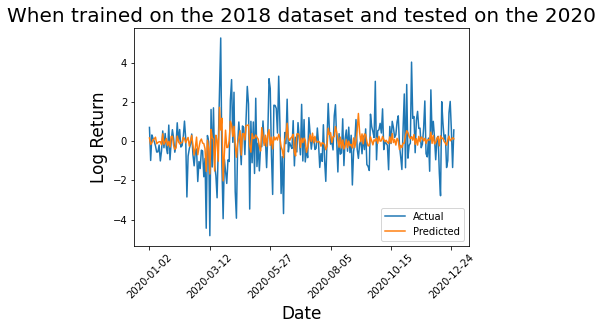

In [11]:
# plot the actual and predicted values

add_dates.plot(x = 'Date', y = ['Actual','Predicted'])
plt.xlabel('Date', fontsize = 17)
plt.ylabel('Log Return', fontsize = 17)
plt.xticks(rotation=45)
plt.title("When trained on the 2018 dataset and tested on the 2020", fontsize = 20)
plt.show()

In [12]:
# get the mse
from sklearn import metrics

print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_predict))

Mean Squared Error: 1.4768899169185352
